In [1]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, order, record
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from trading_calendars.exchange_calendar_binance import BinanceExchangeCalendar
import pandas as pd
from trading_calendars import get_calendar
import pyfolio as pf
import numpy as np

C:\Users\cmial\anaconda3\envs\zip38\lib\site-packages\zipline\__init__.py:45: UserWarning: Found TradingCalendar instances after zipline import.
Zipline startup will be much slower until this is fixed!
  warnings.warn(


### A few things to note:
#### 1) zipline enters the ordered stock and amount in the order book (order() function). After the handle_data() function has finished, zipline looks for any open orders and tries to fill them. If the trading volume is high enough for this stock, the order is executed after adding the *commission* and applying the *slippage model* which models the influence of your order on the stock price, so your algorithm will be charged more than just the stock price. 

#### 2) Order execution - When your algorithm places an order on a given bar, the order begins filling until the next bar regardless of the slippage model used. This way, the backtester guards the algorithm against lookahead bias.

In [2]:
def initialize(context):
    context.udy = symbol("ETHBTC")
    context.has_ordered = False  
    context.n_udy_to_buy = 100

In [3]:
def handle_data(context, data):
    
    # record price for further inspection
    record(price=data.current(context.udy, 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(context.udy, context.n_udy_to_buy)
        
        # setting up a flag for holding a position
        context.has_ordered = True

In [4]:
# standard analysis provided by pyFolio

def analyze_py(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    print(returns.cumsum())
    fig = pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
    for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
    

In [5]:
# customized analysis

def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(511)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    ax = fig.add_subplot(512)
    ax.plot(perf['gross_leverage'], 
            label = 'Exposure', linestyle='-', linewidth=1.0) 
    ax.legend()
    ax.grid(True)
 
    ax = fig.add_subplot(513)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    
    ax = fig.add_subplot(514)
    ax.plot(perf['max_drawdown'], label='max drawdown', linestyle='-.', linewidth=1.0)   
    ax.legend()
    ax.grid(True)
    
    # calculate 6 months rolling sharp ratio
    # risk free rate 2%
#     perf['6m_rolling_SR'] = perf['returns'].rolling(180).apply(lambda x: (x.mean() - 0.02))
#     perf.fillna(0, inplace = True)
#     print(perf['6m_rolling_SR'])
    def my_rolling_sharpe(y):
        return np.sqrt(126) * (y.mean() / y.std())

    ax = fig.add_subplot(515)
    perf['6m_rolling_SR'] = perf['returns'].rolling(180).apply(my_rolling_sharpe) # to revisit
#     print(perf['6m_rolling_SR'])
    ax.plot(perf['6m_rolling_SR'], label='Sharpe', linestyle='-', lw=2, color='orange')
#     perf[perf['6m_rolling_SR'] > 0]["6m_rolling_SR"].plot(style='-', lw=2, color='orange', 
#                                          label='Sharpe', figsize = (10,7))
    ax.legend()
    ax.grid(True)

In [6]:
# calculate sharp ratio
# risk_free_rate = 0.02 # 10 year Treasury bond
# daily_rf_return = (1 + risk_free_rate)** 1/252 - 1
# daily_rf_return

Wall time: 1min 5s


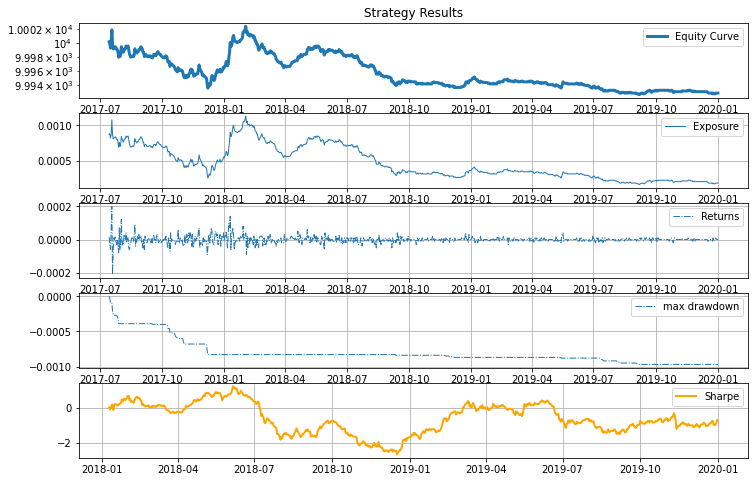

In [7]:
%%time
start_date = pd.Timestamp(datetime(2017, 7, 14, tzinfo=pytz.UTC))
end_date = pd.Timestamp(datetime(2019, 12, 31, tzinfo=pytz.UTC))

results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    trading_calendar = get_calendar("Binance"),
    analyze=analyze, # customized analysis
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='minute',
    bundle='binance_1m',
#     benchmark_returns=None
)

In [ ]:
# %%time
# start_date = pd.Timestamp(datetime(2017, 7, 14, tzinfo=pytz.UTC))
# end_date = pd.Timestamp(datetime(2019, 12, 31, tzinfo=pytz.UTC))

# results = run_algorithm(
#     start=start_date,
#     end=end_date,
#     initialize=initialize,
#     trading_calendar = get_calendar("Binance"),
#     analyze=analyze_py, # pyfolio standard analysis
#     handle_data=handle_data,
#     capital_base=10000,
#     data_frequency='minute',
#     bundle='binance_1m',
# #     benchmark_returns=None
# )

In [8]:
pd.set_option('display.max_columns', None)
results.head()

,period_open,period_close,ending_value,starting_cash,ending_cash,returns,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,short_exposure,orders,transactions,positions,gross_leverage,starting_exposure,net_leverage,ending_exposure,starting_value,price,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe,sortino,6m_rolling_SR
2017-07-14 23:59:00+00:00,2017-07-14 00:00:00+00:00,2017-07-14 23:59:00+00:00,8.736,10000.000000,9991.418759,0.000015,10000.154759,1,0,8.736,0.0,8.736,0.154759,-8.581240,0.0,"[{'id': '3f754c03156c483884569a6680c2d233', 'd...","[{'amount': 3, 'dt': 2017-07-14 04:18:00+00:00...","[{'sid': Equity(0 [ETHBTC]), 'amount': 96, 'co...",0.000874,0.000,0.000874,8.736,0.000,0.091,0.00000,0.000874,0.0,0.0,1,2017-07,0.000015,NaN,0.0,NaN,None,None,NaN,NaN,NaN
2017-07-15 23:59:00+00:00,2017-07-15 00:00:00+00:00,2017-07-15 23:59:00+00:00,8.800,9991.418759,9991.050577,-0.000030,9999.850577,1,0,8.800,0.0,8.800,-0.304182,-0.368182,0.0,"[{'id': '3f754c03156c483884569a6680c2d233', 'd...","[{'amount': 1, 'dt': 2017-07-15 00:54:00+00:00...","[{'sid': Equity(0 [ETHBTC]), 'amount': 100, 'c...",0.000880,8.736,0.000880,8.800,8.736,0.088,-0.00003,0.000880,0.0,0.0,2,2017-07,-0.000015,0.000515,0.0,0.0,None,None,-3.654557,-5.513924,NaN
2017-07-16 23:59:00+00:00,2017-07-16 00:00:00+00:00,2017-07-16 23:59:00+00:00,8.200,9991.050577,9991.050577,-0.000060,9999.250577,1,0,8.200,0.0,8.200,-0.600000,0.000000,0.0,[],[],"[{'sid': Equity(0 [ETHBTC]), 'amount': 100, 'c...",0.000820,8.800,0.000820,8.200,8.800,0.082,-0.00009,0.000880,0.0,0.0,3,2017-07,-0.000075,0.000604,0.0,0.0,None,None,-10.427263,-10.210405,NaN
2017-07-17 23:59:00+00:00,2017-07-17 00:00:00+00:00,2017-07-17 23:59:00+00:00,8.800,9991.050577,9991.050577,0.000060,9999.850577,1,0,8.800,0.0,8.800,0.600000,0.000000,0.0,[],[],"[{'sid': Equity(0 [ETHBTC]), 'amount': 100, 'c...",0.000880,8.200,0.000880,8.800,8.200,0.088,-0.00009,0.000880,0.0,0.0,4,2017-07,-0.000015,0.000835,0.0,0.0,None,None,-1.126441,-1.762552,NaN
2017-07-18 23:59:00+00:00,2017-07-18 00:00:00+00:00,2017-07-18 23:59:00+00:00,10.800,9991.050577,9991.050577,0.000200,10001.850577,1,0,10.800,0.0,10.800,2.000000,0.000000,0.0,[],[],"[{'sid': Equity(0 [ETHBTC]), 'amount': 100, 'c...",0.001080,8.800,0.001080,10.800,8.800,0.108,-0.00009,0.001080,0.0,0.0,5,2017-07,0.000185,0.001617,0.0,0.0,None,None,5.767296,19.530494,NaN


#### A simple strategy , "buy and hold" of 100 ETHBTC order is filled in two days.

In [9]:
# day 1, 97 orders filled
results["transactions"][0]

[{'amount': 3,
  'dt': Timestamp('2017-07-14 04:18:00+0000', tz='UTC'),
  'price': 0.08604300000000001,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 1,
  'dt': Timestamp('2017-07-14 04:19:00+0000', tz='UTC'),
  'price': 0.08504250000000001,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 1,
  'dt': Timestamp('2017-07-14 04:37:00+0000', tz='UTC'),
  'price': 0.08604300000000001,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 1,
  'dt': Timestamp('2017-07-14 04:51:00+0000', tz='UTC'),
  'price': 0.08604300000000001,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 1,
  'dt': Timestamp('2017-07-14 05:44:00+0000', tz='UTC'),
  'price': 0.08604300000000001,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETH

In [10]:
# day 2, remaining 3 order filled
results["transactions"][1]

[{'amount': 1,
  'dt': Timestamp('2017-07-15 00:54:00+0000', tz='UTC'),
  'price': 0.092046,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 1,
  'dt': Timestamp('2017-07-15 02:45:00+0000', tz='UTC'),
  'price': 0.090045,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None},
 {'amount': 2,
  'dt': Timestamp('2017-07-15 04:07:00+0000', tz='UTC'),
  'price': 0.0910455,
  'order_id': '3f754c03156c483884569a6680c2d233',
  'sid': Equity(0 [ETHBTC]),
  'commission': None}]